## Tips & tricks 4 : model with redundant storages

In this model, we will have a load that can be provided by two competitive storages.

####  Base model

In [1]:
import math

import matplotlib.pyplot as plt
import pandas as pd

from eesrep import Eesrep
from eesrep.components.bus import GenericBus
from eesrep.components.sink_source import FatalSink, FatalSource, Sink, Source
from eesrep.components.storage import GenericStorage

In [2]:
model = Eesrep(interface="docplex")

load_df = pd.DataFrame({"time": list(range(50)), 
                            "value": [0 if i <= 25 else 300 for i in range(50)]})

wind_df = pd.DataFrame({"time": list(range(50)), 
                            "value": [150 for _ in range(50)]})

load = FatalSink(name="load", 
                        sink_flow = load_df)

wind = FatalSource(name="wind", 
                        source_flow = wind_df)

storage_1 = GenericStorage(name="storage_1", p_max=500, storage_max=2000, efficiency=1., init_storage=0.)
storage_2 = GenericStorage(name="storage_2", p_max=500, storage_max=2000, efficiency=1., init_storage=0.)

model.add_component(wind)
model.add_component(load)
model.add_component(storage_1)
model.add_component(storage_2)

bus = GenericBus("bus")
model.add_component(bus)
                        
model.plug_to_bus(io = wind.power_out, bus_io = bus.input, factor=1., offset=0.)
model.plug_to_bus(io = load.power_in, bus_io = bus.output, factor=1., offset=0.)

model.plug_to_bus(io = storage_1.flow, bus_io = bus.output, factor=1., offset=0.)
model.plug_to_bus(io = storage_2.flow, bus_io = bus.output, factor=1., offset=0.)

model.define_time_range(time_step = 1., 
                        time_shift = 1, 
                        future_size = 50, 
                        horizon_count = 1)
                        
model.solve()

Running first time step


As we can see in the results below, have undeterministic behaviors, charging each others, eventually giving a chaotic behavior.

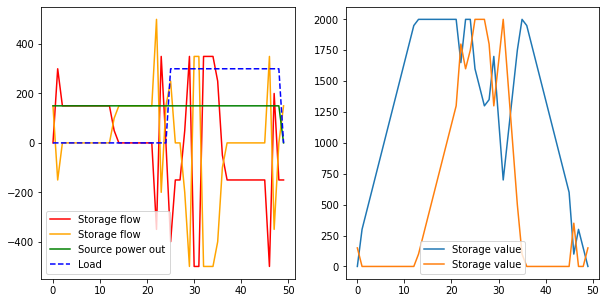

In [3]:
results = model.get_results(as_dataframe=False)

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(results["storage_1"]["flow"], label = "Storage flow", color="r")
plt.plot(results["storage_2"]["flow"], label = "Storage flow", color="orange")
plt.plot(results["wind"]["power_out"], label = "Source power out", color="g")
plt.plot(results["load"]["power_in"], label = "Load", linestyle = "dashed", color="blue")
plt.legend()
plt.subplot(122)
plt.plot(results["storage_1"]["storage"], label = "Storage value")
plt.plot(results["storage_2"]["storage"], label = "Storage value")
plt.legend()
plt.show()

####  Tweaked model

The behavior showed above can be fixed by adding a small and different price to each battery, for this, we will plug the storage value to a Sink component. That way, the greater the storage price, the less the solver will want to use it, it will therefore be charged last, and discharged first.

In [4]:
model = Eesrep(interface="docplex")

load_df = pd.DataFrame({"time": list(range(50)), 
                            "value": [0 if i <= 25 else 300 for i in range(50)]})

wind_df = pd.DataFrame({"time": list(range(50)), 
                            "value": [150 for _ in range(50)]})

load = FatalSink(name="load", 
                        sink_flow = load_df)

wind = FatalSource(name="wind", 
                        source_flow = wind_df)

storage_1 = GenericStorage(name="storage_1", p_max=500, storage_max=2000, efficiency=1., init_storage=0.)
storage_2 = GenericStorage(name="storage_2", p_max=500, storage_max=2000, efficiency=1., init_storage=0.)
price_storage = Sink(name="price_storage", p_min = 0., p_max = None, price=1.)

model.add_component(wind)
model.add_component(load)
model.add_component(storage_1)
model.add_component(storage_2)
model.add_component(price_storage)

bus = GenericBus("bus")
model.add_component(bus)
                        
model.plug_to_bus(io = wind.power_out, bus_io = bus.input, factor=1., offset=0.)
model.plug_to_bus(io = load.power_in, bus_io = bus.output, factor=1., offset=0.)

model.plug_to_bus(io = storage_1.flow, bus_io = bus.output, factor=1., offset=0.)
model.plug_to_bus(io = storage_2.flow, bus_io = bus.output, factor=1., offset=0.)

model.add_link(io_1=storage_2.storage, io_2=price_storage.power_in, factor=0.00000001, offset=0.)

model.define_time_range(time_step = 1., 
                        time_shift = 1, 
                        future_size = 50, 
                        horizon_count = 1)
                        
model.solve()

Running first time step


We can see below that the expected behavior is now respected.

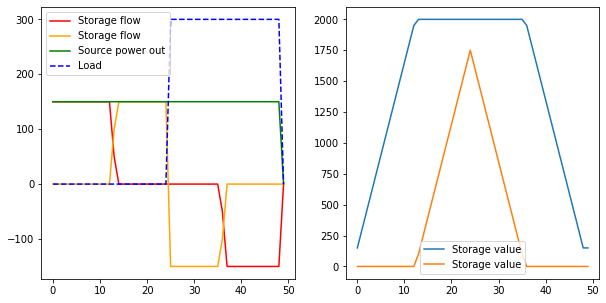

In [5]:
results = model.get_results(as_dataframe=False)

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(results["storage_1"]["flow"], label = "Storage flow", color="r")
plt.plot(results["storage_2"]["flow"], label = "Storage flow", color="orange")
plt.plot(results["wind"]["power_out"], label = "Source power out", color="g")
plt.plot(results["load"]["power_in"], label = "Load", linestyle = "dashed", color="blue")
plt.legend()
plt.subplot(122)
plt.plot(results["storage_1"]["storage"], label = "Storage value")
plt.plot(results["storage_2"]["storage"], label = "Storage value")
plt.legend()
plt.show()